Lei de Gauss para o campo elétrico $$\nabla \cdot E = \frac{\rho}{\epsilon_0} $$
Lei de Gauss para o campo magnético $$\nabla \cdot B = 0$$
Lei de Faraday de indução $$\nabla \times E = - \frac{\partial B}{\partial t}$$
Lei de Ampère sem corrente de condução $$\nabla \times B = \mu_0 \epsilon_0 \frac{\partial E}{\partial t}$$

In [1]:
import torch
import numpy as np
import torch.nn as nn
import magpylib as magpy
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Definir a rede neural PINN
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.output_layer = nn.Linear(layers[-1], 4) # Ex, Ey, Bx, By

    def forward(self, x):
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        return self.output_layer(x)

# Função de perda (loss) incorporando as Equações de Maxwell
def maxwell_loss(model, x, y):
    x.requires_grad = True
    y.requires_grad = True
    inputs = torch.cat([x, y], dim=1)

    outputs = model(inputs)
    Ex_pred, Ey_pred, Bx_pred, By_pred = outputs[:, 0], outputs[:, 1], outputs[:, 2], outputs[:, 3]

    Ex_x = torch.autograd.grad(Ex_pred, x, torch.ones_like(Ex_pred), create_graph=True)[0]
    Ey_y = torch.autograd.grad(Ey_pred, y, torch.ones_like(Ey_pred), create_graph=True)[0]
    Bx_x = torch.autograd.grad(Bx_pred, x, torch.ones_like(Bx_pred), create_graph=True)[0]
    By_y = torch.autograd.grad(By_pred, y, torch.ones_like(By_pred), create_graph=True)[0]

    # Equações de Maxwell
    div_E = Ex_x + Ey_y
    div_B = Bx_x + By_y

    loss = (div_E**2).mean() + (div_B**2).mean()

    return loss

# Treinamento
def train(model, x_train, y_train, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = maxwell_loss(model, x_train, y_train)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    return loss_history

In [3]:
def generate_training_data():
    grid = np.mgrid[-50:50:100j, -50:50:100j, 0:0:1j].T[0]
    X, Y, _ = np.moveaxis(grid, 2, 0)
    
    cyl = magpy.magnet.Cylinder(polarization=(0.5, 0.5, 0), dimension=(40, 20))

    B = cyl.getB(grid)
    Bx, By, _ = np.moveaxis(B, 2, 0)

    E = cyl.getH(grid)
    Ex, Ey, _ = np.moveaxis(E, 2, 0)

    return X, Y, E, Ex, Ey, B, Bx, By

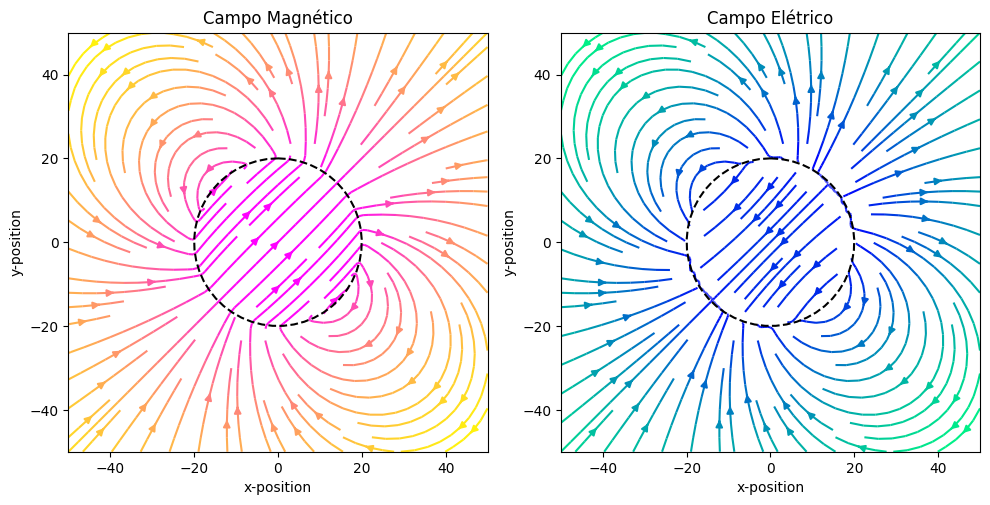

In [4]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10, 10))

X, Y, E, Ex, Ey, B, Bx, By = generate_training_data()
ax1.streamplot(X, Y, Bx, By, color=np.log(np.linalg.norm(B, axis=2)), cmap='spring_r')
ax1.set_title('Campo Magnético')
ax2.streamplot(X, Y, Ex, Ey, color=np.log(np.linalg.norm(E, axis=2)), cmap='winter_r')
ax2.set_title('Campo Elétrico')
for ax in [ax1,ax2]:
    ax.set(
        xlabel='x-position',
        ylabel='y-position',
        aspect=1,
        xlim=(-50,50),
        ylim=(-50,50),
    )
    # Outline magnet boundary
    ts = np.linspace(0, 2 * np.pi, 50)
    ax.plot(20 * np.sin(ts), 20 * np.cos(ts), 'k--')
plt.tight_layout()
plt.show()

Epoch 0, Loss: 0.0001249062188435346
Epoch 100, Loss: 1.6329366303580173e-07
Epoch 200, Loss: 6.886896386504304e-08
Epoch 300, Loss: 4.134002296041217e-08
Epoch 400, Loss: 2.815803767930447e-08
Epoch 500, Loss: 2.0579829396183413e-08
Epoch 600, Loss: 1.5814592302376695e-08
Epoch 700, Loss: 1.2614214561779136e-08
Epoch 800, Loss: 1.0345638123965273e-08
Epoch 900, Loss: 8.664247985734619e-09


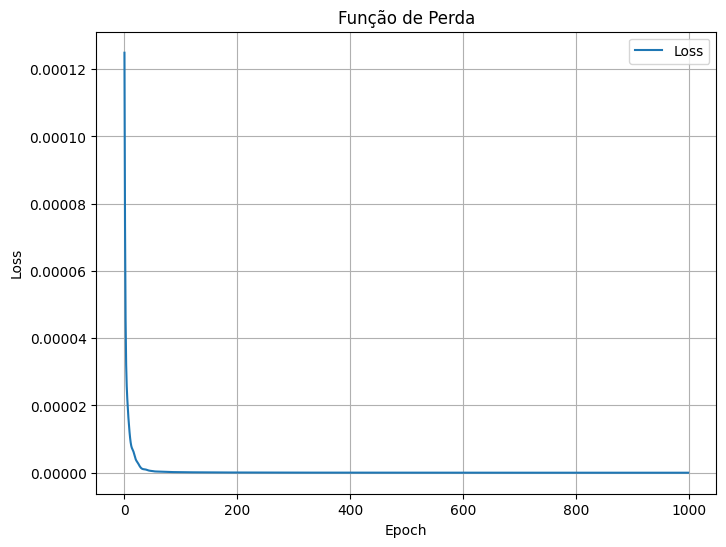

In [5]:
# Gerar dados de treinamento
x, y, _, Ex, Ey, _, Bx, By = generate_training_data()

x_train_tensor = torch.tensor(x.flatten(), dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y.flatten(), dtype=torch.float32).unsqueeze(1)
Ex_train_tensor = torch.tensor(Ex.flatten(), dtype=torch.float32).unsqueeze(1)
Ey_train_tensor = torch.tensor(Ey.flatten(), dtype=torch.float32).unsqueeze(1)
Bx_train_tensor = torch.tensor(Bx.flatten(), dtype=torch.float32).unsqueeze(1)
By_train_tensor = torch.tensor(By.flatten(), dtype=torch.float32).unsqueeze(1)

# Definir e treinar o modelo
model = PINN(layers=[2, 50, 50, 50, 4])
loss_history = train(model, x_train_tensor, y_train_tensor, epochs=1000, learning_rate=1e-3)

# Visualizar a função de perda ao longo das épocas
plt.figure(figsize=(8, 6))
plt.plot(loss_history, label='Loss')
plt.title('Função de Perda')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Função para prever os campos elétrico e magnético usando o modelo treinado
def predict(model, x, y):
    inputs = torch.cat([x, y], dim=1)
    outputs = model(inputs)
    return outputs.detach().numpy()

# Gerar dados de teste
X_test, Y_test, _, Ex_test, Ey_test, _, Bx_test, By_test = generate_training_data()

X_test = torch.tensor(X_test.flatten(), dtype=torch.float32).unsqueeze(1)
Y_test = torch.tensor(Y_test.flatten(), dtype=torch.float32).unsqueeze(1)
Ex_test_tensor = torch.tensor(Ex_test.flatten(), dtype=torch.float32).unsqueeze(1)
Ey_test_tensor = torch.tensor(Ey_test.flatten(), dtype=torch.float32).unsqueeze(1)
Bx_test_tensor = torch.tensor(Bx_test.flatten(), dtype=torch.float32).unsqueeze(1)
By_test_tensor = torch.tensor(By_test.flatten(), dtype=torch.float32).unsqueeze(1)

# Prever usando o modelo PINN
predictions = predict(model, X_test, Y_test)

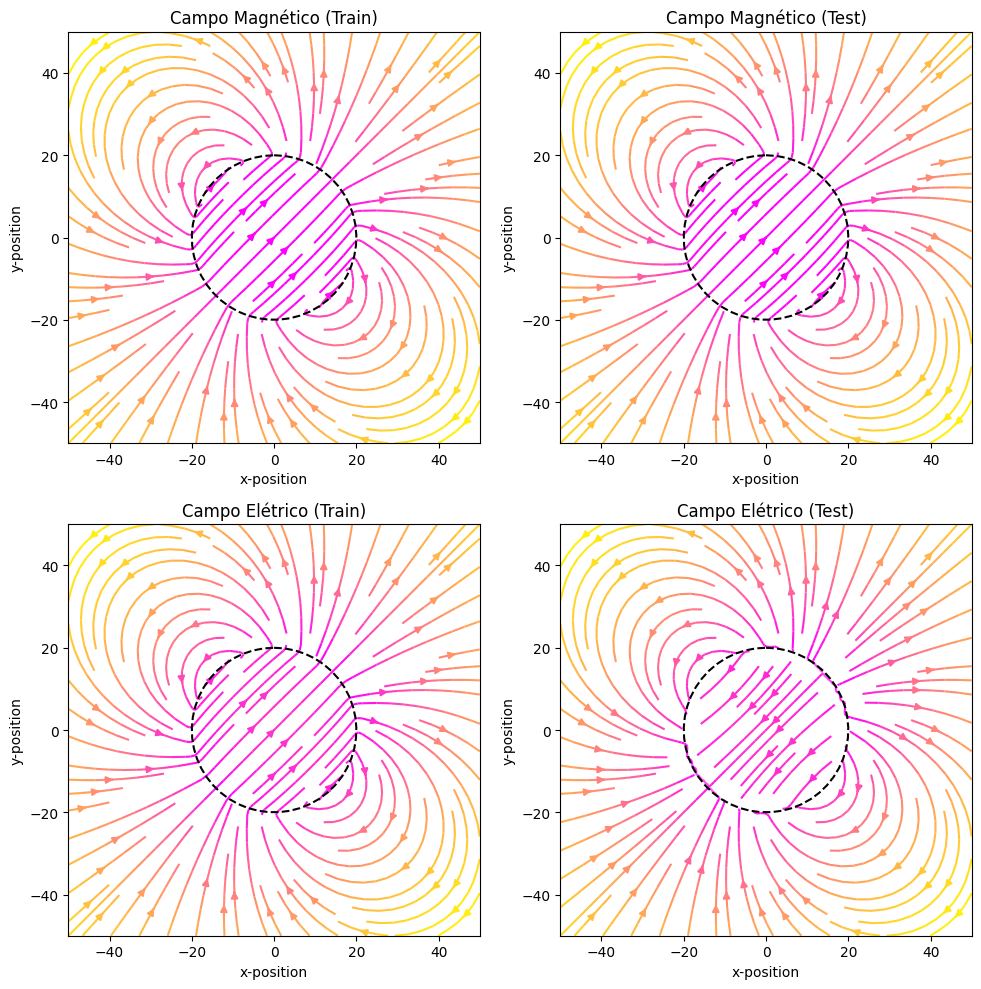

In [59]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2, 2, figsize=(10, 10))

ax1.set_title('Campo Magnético (Train)')
ax1.streamplot(x, y, Bx, By, color=np.log(np.linalg.norm(B, axis=2)), cmap='spring_r')

ax2.set_title('Campo Magnético (Test)')
ax2.streamplot(x, y, Bx_test, By_test, color=np.log(np.linalg.norm(B, axis=2)), cmap='spring_r')

ax3.set_title('Campo Elétrico (Train)')
ax3.streamplot(x, y, Ex, Ey, color=np.log(np.linalg.norm(E, axis=2)), cmap='spring_r')

ax4.set_title('Campo Elétrico (Test)')
ax4.streamplot(x, y, Ex_test, Ey_test, color=np.log(np.linalg.norm(E, axis=2)), cmap='spring_r')

for ax in [ax1,ax2,ax3,ax4]:
    ax.set(
        xlabel='x-position',
        ylabel='y-position',
        aspect=1,
        xlim=(-50,50),
        ylim=(-50,50),
    )
    # Outline magnet boundary
    ts = np.linspace(0, 2 * np.pi, 50)
    ax.plot(20 * np.sin(ts), 20 * np.cos(ts), 'k--')
plt.tight_layout()
plt.show()